# Crash Reporting US | Exploratory Analysis
Goal: describe the most common conditions and patterns present in crash records and explore how factors relate to crash severity.


## 1. Introduction
### 1.1 Context for readers
Traffic crashes are a major public safety issue that lead to injuries, fatalities, and economic losses.

### 1.2 Motivation
Understanding common crash environments and driver/vehicle factors can inform safety awareness and policy discussions.

### 1.3 Research questions
1) Accident hotspots: which road types appear most often in crash records?
2) Time patterns: when do crashes occur most frequently?
3) Collision causes: what driver/vehicle factors are most common in crashes?
4) Environmental impacts: how do weather, surface, light, and traffic control relate to severity?
5) Vehicle conditions: do vehicle age and size show different damage patterns?


## 2. Data
### 2.1 Technical description
Dataset: ?Crash Reporting - Drivers Data? (Montgomery County, MD; ACRS system).
We use the CSV file provided with the project.


In [85]:
import pandas as pd
import numpy as np

df = pd.read_csv("crash_data.csv", encoding="latin1", low_memory=False)
df.head(3)


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3170003V,240000438,Montgomery County Police,Property Damage Crash,01/03/2024 14:55,NaN,NaN,NaN,NaN,IN FRONT OF 18900 BIRDSEYE DR,...,0,No,No,2017,LEXUS,SUV,NO MISUSE,39.165005,-77.249310,"(39.16500483, -77.24931)"
1,MCP3254003K,230072050,Montgomery County Police,Injury Crash,12/16/2023 12:36:00 PM,Maryland (State),GERMANTOWN RD,County,MIDDLEBROOK RD,NaN,...,35,No,No,2010,TOYT,PRIUS,NO MISUSE,39.178776,-77.267190,"(39.17877577, -77.26718974)"
2,EJ7887003Q,230074270,Gaithersburg Police Depar,Injury Crash,12/29/2023 12:00:00 PM,Maryland (State),GREAT SENECA HWY,Municipality,KENTLANDS BLVD,NaN,...,35,No,No,2021,SUBARU,FORRESTER,NO MISUSE,39.123574,-77.231769,"(39.12357374, -77.231769)"


In [86]:
# Dataset overview
overview = pd.DataFrame({
    "n_rows": [len(df)],
    "n_cols": [df.shape[1]],
    "n_numeric": [df.select_dtypes(include=["number"]).shape[1]],
    "n_categorical": [df.select_dtypes(include=["object"]).shape[1]],
})
overview


,n_rows,n_cols,n_numeric,n_categorical
0,167330,41,4,37


### 2.2 Research plan
We structure the analysis around five questions, linking each to relevant variables and outcomes.


In [87]:
plan = pd.DataFrame({
    "No.": [1,2,3,4,5],
    "Research Question": [
        "Accident hotspots",
        "Time patterns",
        "Collision causes",
        "Environmental impacts",
        "Vehicle conditions"
    ],
    "Key Variables": [
        "Route Type, Cross-Street Type",
        "Crash Date/Time",
        "Driver Substance Abuse, Driver Distracted By, Vehicle Movement, Equipment Problems",
        "Weather, Surface Condition, Light, Traffic Control, Speed Limit",
        "Vehicle Year, Vehicle Body Type"
    ],
    "Outcomes": [
        "N/A",
        "N/A",
        "Vehicle Damage Extent",
        "Injury Severity, Vehicle Damage Extent",
        "Vehicle Damage Extent"
    ]
})
plan


,No.,Research Question,Key Variables,Outcomes
0,1,Accident hotspots,"Route Type, Cross-Street Type",N/A
1,2,Time patterns,Crash Date/Time,N/A
2,3,Collision causes,"Driver Substance Abuse, Driver Distracted By, ...",Vehicle Damage Extent
3,4,Environmental impacts,"Weather, Surface Condition, Light, Traffic Con...","Injury Severity, Vehicle Damage Extent"
4,5,Vehicle conditions,"Vehicle Year, Vehicle Body Type",Vehicle Damage Extent


### 2.3 Data preparation and missing values
- Remove full-row duplicates.
- Drop identifiers and highly-missing or irrelevant fields.
- Convert crash time to datetime and derive time features.
- Clean abnormal Vehicle Year values (e.g., 0, 9999, future years).
- Treat missing categories as ?Missing/Unknown? for key categorical fields.


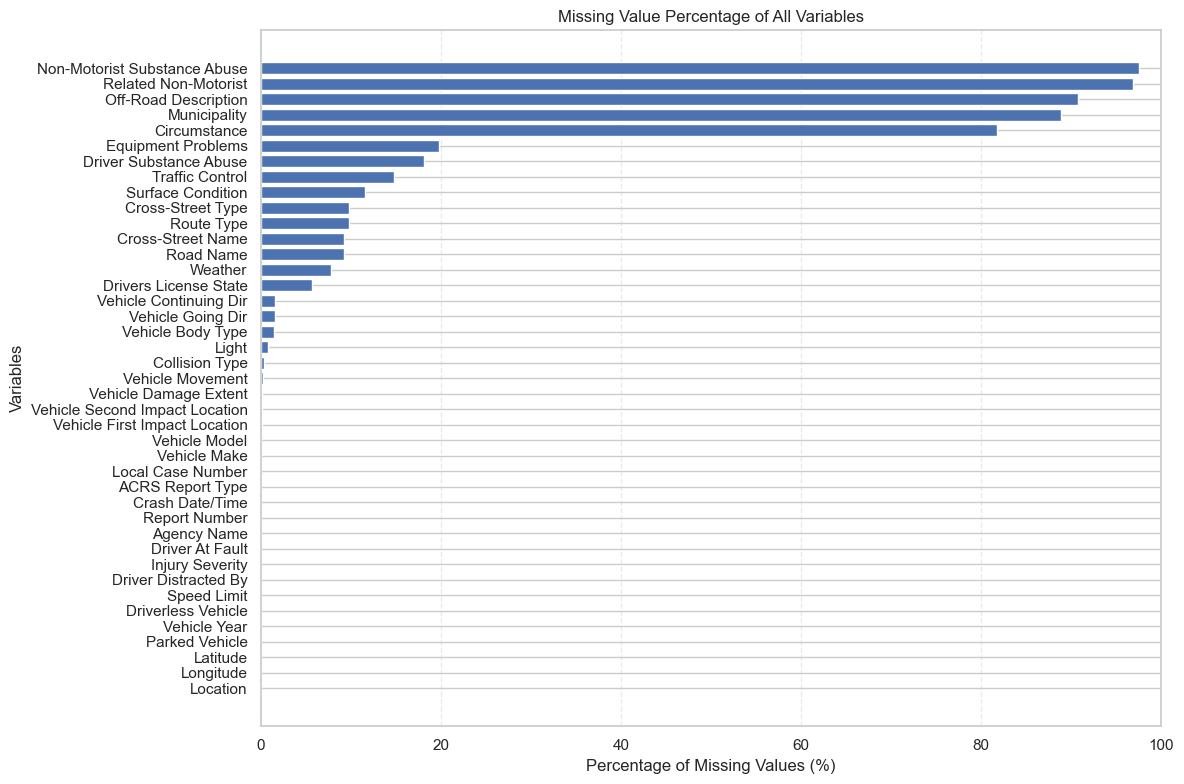

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1) Missing % per column
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)

# Optional: plot only columns with at least 1% missing
# missing_pct = missing_pct[missing_pct > 1]

# 2) Plot (horizontal bars)
plt.figure(figsize=(12, 8))
plt.barh(missing_pct.index, missing_pct.values)
plt.gca().invert_yaxis()  # largest on top

plt.title("Missing Value Percentage of All Variables")
plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Variables")
plt.xlim(0, 100)

# Grid similar vibe to ggplot
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# # Missingness pattern (sample)
# sample = df.sample(500, random_state=42)
# plt.figure(figsize=(8,4))
# sns.heatmap(sample.isna(), cbar=False)
# plt.title("Missingness pattern (sample of 500 rows)")
# plt.xlabel("Variables")
# plt.ylabel("Rows")
# plt.tight_layout()
# plt.show()


In [89]:
# Remove exact duplicates
df = df.drop_duplicates()

# Drop identifiers and high-missing or irrelevant columns
drop_cols = [
    "Report Number", "Local Case Number", "Parked Vehicle", "Driverless Vehicle", "Driver At Fault",
    "Non-Motorist Substance Abuse", "Related Non-Motorist", "ACRS Report Type", "Agency Name", "Latitude", "Longitude",
    "Off-Road Description", "Municipality", "Circumstance", "Collision Type", "Drivers License State", "Vehicle Model",
    "Location", "Road Name", "Cross-Street Name", "Vehicle Going Dir", "Vehicle Continuing Dir" , "Vehicle First Impact Location" , "Vehicle Second Impact Location"
    
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Missing/Unknown for key categoricals
missing_as_category = [
    "Weather", "Surface Condition", "Light", "Traffic Control",
    "Driver Substance Abuse", "Driver Distracted By", "Equipment Problems",
    "Vehicle Movement", "Vehicle Body Type", "Vehicle Damage Extent",
    "Route Type", "Cross-Street Type", "Injury Severity"
]
for c in missing_as_category:
    if c in df.columns:
        df[c] = df[c].astype("object").fillna("Missing/Unknown")


overview_after = pd.DataFrame({
    "n_rows": [len(df)],
    "n_cols": [df.shape[1]],
    "n_numeric": [df.select_dtypes(include=["number"]).shape[1]],
    "n_categorical": [df.select_dtypes(include=["object"]).shape[1]],
})
overview_after

,n_rows,n_cols,n_numeric,n_categorical
0,167326,17,2,15


C:\Users\liorbj\AppData\Local\Temp\ipykernel_37148\1334882079.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  missing_pct_refined = (df.applymap(lambda x: x == "Missing/Unknown").mean() * 100).sort_values(ascending=False)


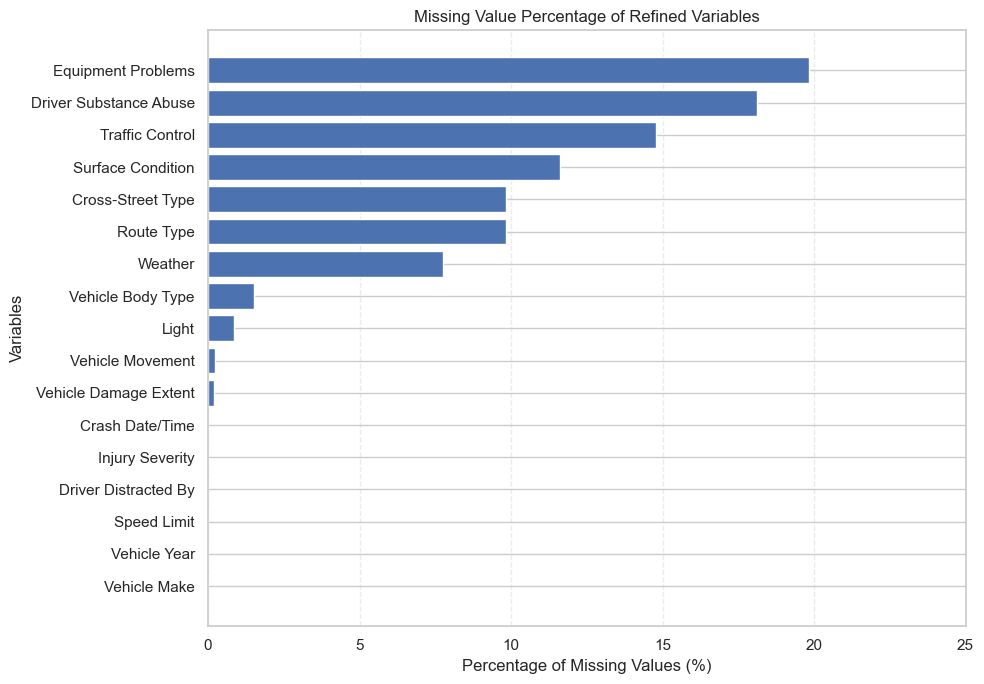

In [90]:
import matplotlib.pyplot as plt

missing_pct_refined = (df.applymap(lambda x: x == "Missing/Unknown").mean() * 100).sort_values(ascending=False)

plt.figure(figsize=(10, 7))
plt.barh(missing_pct_refined.index, missing_pct_refined.values)
plt.gca().invert_yaxis()

plt.title("Missing Value Percentage of Refined Variables")
plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Variables")
plt.xlim(0, 25)  # matches your plot scale

plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\liorbj\AppData\Local\Temp\ipykernel_37148\2371908037.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  miss = df_s.applymap(lambda x: str(x).strip() == "Missing/Unknown")


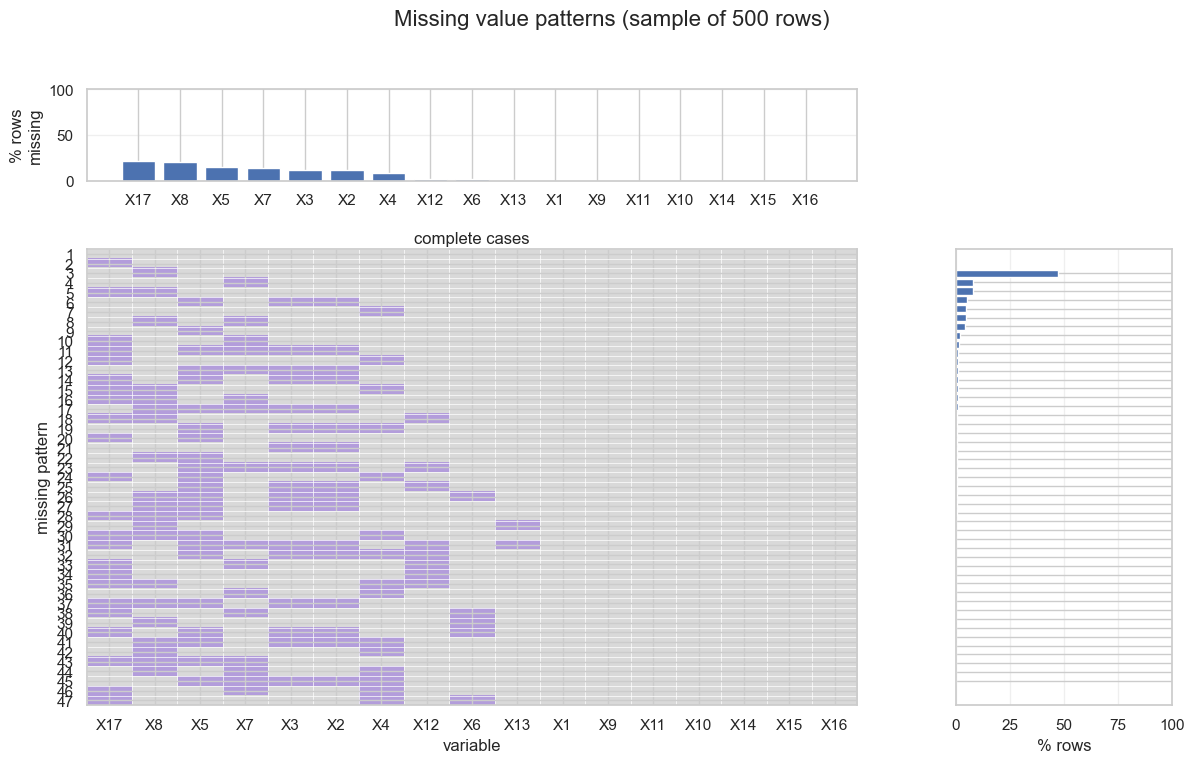

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

vars_order = [
    "Crash Date/Time",
    "Route Type",
    "Cross-Street Type",
    "Weather",
    "Surface Condition",
    "Light",
    "Traffic Control",
    "Driver Substance Abuse",
    "Injury Severity",
    "Driver Distracted By",
    "Vehicle Damage Extent",
    "Vehicle Body Type",
    "Vehicle Movement",
    "Speed Limit",
    "Vehicle Year",
    "Vehicle Make",
    "Equipment Problems",
]

var_to_num = {name: i + 1 for i, name in enumerate(vars_order)}

# ----------------------------
# Sample data
# ----------------------------
sample_n = 500
df_s = df[vars_order].sample(n=sample_n)

# Boolean missingness mask
miss = df_s.applymap(lambda x: str(x).strip() == "Missing/Unknown")

# ----------------------------
# 1) SORT VARIABLES by % missing
# ----------------------------
missing_pct = miss.mean(axis=0) * 100
missing_pct = missing_pct.sort_values(ascending=False)

vars_sorted = missing_pct.index.tolist()

# Reorder mask to match sorted variables
miss = miss[vars_sorted]

# ----------------------------
# 2) SORT MISSING PATTERNS by % rows
# ----------------------------
patterns = miss.apply(lambda r: tuple(r.values), axis=1)
pattern_counts = patterns.value_counts().sort_values(ascending=False)

pattern_matrix = np.array(pattern_counts.index.tolist(), dtype=bool)
pattern_freq_pct = (pattern_counts.values / len(df_s)) * 100

# ----------------------------
# 3) Plot
# ----------------------------
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    height_ratios=[1, 5],
    width_ratios=[5, 1.4],
    hspace=0.25, wspace=0.2
)

ax_top = fig.add_subplot(gs[0, 0])
ax_mid = fig.add_subplot(gs[1, 0])
ax_right = fig.add_subplot(gs[1, 1])

# ---- Top bar chart (sorted by % missing)
x = np.arange(len(vars_sorted))
ax_top.bar(x, missing_pct.values)
ax_top.set_ylim(0, 100)
ax_top.set_xticks(x)
ax_top.set_xticklabels([f"X{var_to_num[v]}" for v in vars_sorted])
ax_top.set_ylabel("% rows\nmissing")
ax_top.grid(axis="y", alpha=0.3)

# ---- Heatmap (aligned with sorted variables)
img = pattern_matrix.astype(int)
cmap = ListedColormap(["#d9d9d9", "#b39ddb"])

ax_mid.imshow(img, aspect="auto", interpolation="nearest", cmap=cmap)

ax_mid.set_xticks(x)
ax_mid.set_xticklabels([f"X{var_to_num[v]}" for v in vars_sorted])
ax_mid.set_yticks(np.arange(len(pattern_counts)))
ax_mid.set_yticklabels(np.arange(1, len(pattern_counts) + 1))
ax_mid.set_xlabel("variable")
ax_mid.set_ylabel("missing pattern")

ax_mid.text(
    0.5, 1.04, "complete cases",
    transform=ax_mid.transAxes,
    ha="center", va="top",
    fontsize=12
)

ax_mid.set_xticks(np.arange(-0.5, len(vars_sorted), 1), minor=True)
ax_mid.set_yticks(np.arange(-0.5, len(pattern_counts), 1), minor=True)
ax_mid.grid(which="minor", color="white", linewidth=0.5)
ax_mid.tick_params(which="minor", bottom=False, left=False)

# ---- Right bar chart (sorted by % rows)
y = np.arange(len(pattern_counts))
ax_right.barh(y, pattern_freq_pct)
ax_right.invert_yaxis()
ax_right.set_xlim(0, 100)
ax_right.set_xlabel("% rows")
ax_right.set_yticks(y)
ax_right.set_yticklabels([])
ax_right.grid(axis="x", alpha=0.3)

fig.suptitle("Missing value patterns (sample of 500 rows)", fontsize=16)
plt.show()


## 3. Results
### 3.1 Accident Hotspots


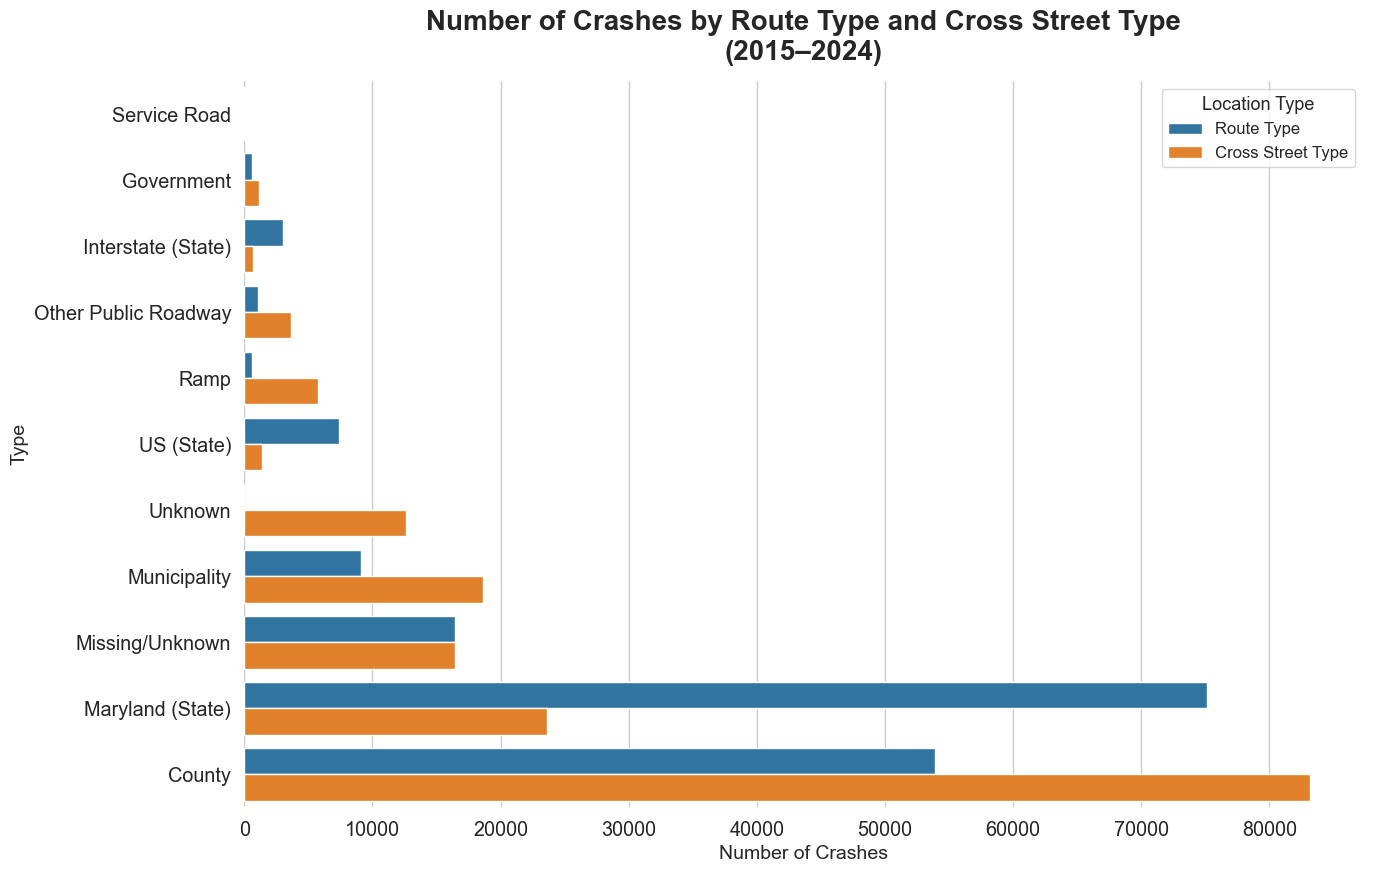

In [91]:

route_counts = (
    df["Route Type"]
    .value_counts()
    .reset_index()
)
route_counts.columns = ["type", "count"]
route_counts["location"] = "Route Type"

cross_counts = (
    df["Cross-Street Type"]
    .value_counts()
    .reset_index()
)
cross_counts.columns = ["type", "count"]
cross_counts["location"] = "Cross Street Type"

plot_df = pd.concat([route_counts, cross_counts], ignore_index=True)


plot_df["type"] = pd.Categorical(
    plot_df["type"],
    categories=plot_df.groupby("type")["count"].sum().sort_values().index,
    ordered=True
)


sns.set_theme(style="whitegrid", font_scale=1.3)

plt.figure(figsize=(14, 9))

palette = {
    "Route Type": "#1f77b4",        # blue
    "Cross Street Type": "#ff7f0e"  # orange
}

ax = sns.barplot(
    data=plot_df,
    x="count",
    y="type",
    hue="location",
    palette=palette
)

ax.set_title(
    "Number of Crashes by Route Type and Cross Street Type\n(2015–2024)",
    fontsize=20,
    weight="bold",
    pad=15
)
ax.set_xlabel("Number of Crashes", fontsize=14)
ax.set_ylabel("Type", fontsize=14)

ax.legend(title="Location Type", fontsize=12, title_fontsize=13)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()



### 3.2 Time Patterns
#### 3.2.1 Yearly & Seasonal Patterns


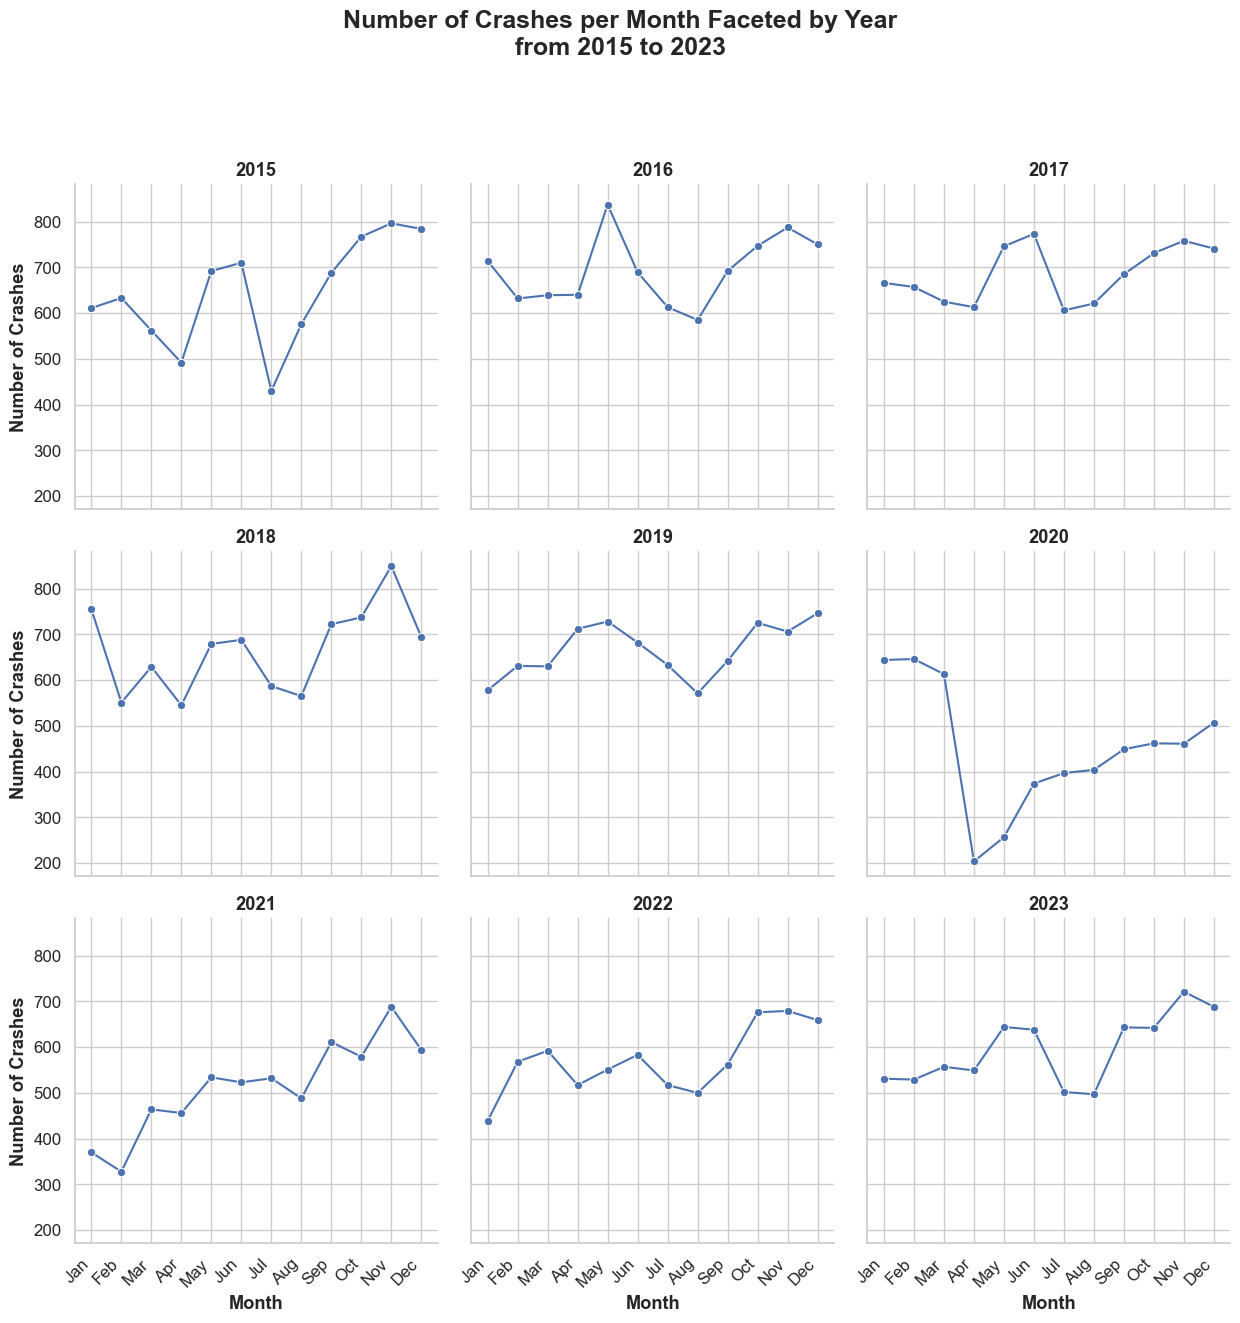

In [112]:

DATE_COL = "Crash Date/Time"
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# Keep only rows with valid dates
df = df.dropna(subset=[DATE_COL])

# ----------------------------
# Extract Year + Month
# ----------------------------
df["Year"] = df[DATE_COL].dt.year
df["Month"] = df[DATE_COL].dt.month

# Filter to 2015–2023 (change if needed)
df = df[(df["Year"] >= 2015) & (df["Year"] <= 2023)]

# ----------------------------
# Count crashes per (Year, Month)
# ----------------------------
monthly_counts = (
    df.groupby(["Year", "Month"])
      .size()
      .reset_index(name="Crashes")
)

# Ensure months are ordered 1..12 and include missing months as zeros
all_years = sorted(monthly_counts["Year"].unique())
full_index = pd.MultiIndex.from_product([all_years, range(1, 13)], names=["Year", "Month"])
monthly_counts = (
    monthly_counts.set_index(["Year", "Month"])
                  .reindex(full_index, fill_value=0)
                  .reset_index()
)

# Month labels
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# ----------------------------
# Plot: Faceted line chart by year
# ----------------------------
sns.set_theme(style="whitegrid", font_scale=1.1)

g = sns.FacetGrid(
    monthly_counts,
    col="Year",
    col_wrap=3,        # 9 panels per row (2015–2023 fits nicely)
    height=4.2,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x="Month",
    y="Crashes",
    marker="o",
    linewidth=1.5
)

# Axis formatting
g.set_axis_labels("Month", "Number of Crashes")
g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_labels, rotation=45, ha="right")

# Title
g.fig.suptitle(
    "Number of Crashes per Month Faceted by Year\nfrom 2015 to 2023",
    fontsize=18,
    weight="bold",
    y=1.05
)

plt.tight_layout()
plt.show()


#### 3.2.2 Weekly & Time Patterns


C:\Users\liorbj\AppData\Local\Temp\ipykernel_37148\2007432167.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["WeekdayName", "Hour"])


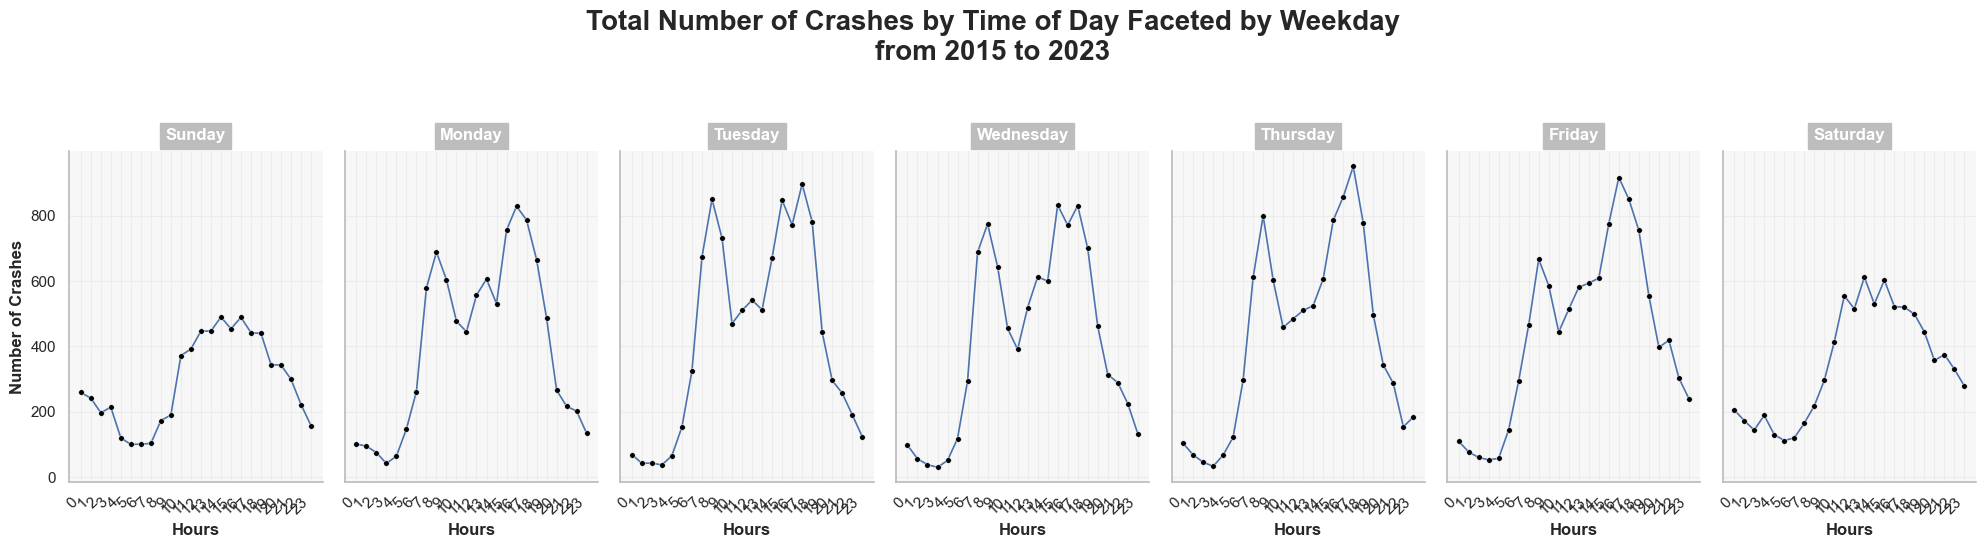

In [117]:

DATE_COL = "Crash Date/Time"  # change if needed
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL])

# Filter years (2015–2023)
df["Year"] = df[DATE_COL].dt.year
df = df[(df["Year"] >= 2015) & (df["Year"] <= 2023)]

# ----------------------------
# Extract hour + weekday
# ----------------------------
df["Hour"] = df[DATE_COL].dt.hour

# Pandas: Monday=0 ... Sunday=6
df["Weekday"] = df[DATE_COL].dt.dayofweek

weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
weekday_map = {6: "Sunday", 0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday"}

df["WeekdayName"] = df["Weekday"].map(weekday_map)
df["WeekdayName"] = pd.Categorical(df["WeekdayName"], categories=weekday_order, ordered=True)

# ----------------------------
# Count crashes by (weekday, hour)
# ----------------------------
hourly_weekday = (
    df.groupby(["WeekdayName", "Hour"])
      .size()
      .reset_index(name="Crashes")
)

# Fill missing hour bins (0..23) for each weekday with zero
full_index = pd.MultiIndex.from_product([weekday_order, range(24)], names=["WeekdayName", "Hour"])
hourly_weekday = (
    hourly_weekday.set_index(["WeekdayName", "Hour"])
                 .reindex(full_index, fill_value=0)
                 .reset_index()
)

# ----------------------------
# Plot (ggplot-like, faceted by weekday)
# ----------------------------
sns.set_theme(
    style="whitegrid",
    rc={
        "axes.facecolor": "#f7f7f7",
        "grid.color": "#e6e6e6",
        "grid.linewidth": 0.8,
        "axes.edgecolor": "#bdbdbd",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
    }
)

g = sns.FacetGrid(
    hourly_weekday,
    col="WeekdayName",
    col_wrap=7,     # one row like your example
    height=5.2,
    aspect=0.55,
    sharey=True
)

# Line + black points
g.map_dataframe(
    sns.lineplot,
    x="Hour",
    y="Crashes",
    color="#4C72B0",
    linewidth=1.2
)

g.map_dataframe(
    sns.scatterplot,
    x="Hour",
    y="Crashes",
    color="black",
    s=16,
    zorder=3
)

# Axis labels/ticks
g.set_axis_labels("Hours", "Number of Crashes")
g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.set_xticks(range(24))
    ax.set_xticklabels([str(h) for h in range(24)], rotation=45, ha="right")
    ax.grid(True, axis="both", alpha=0.6)

# Grey facet headers like ggplot
for ax in g.axes.flat:
    ax.set_title(
        ax.get_title(),
        backgroundcolor="#bdbdbd",
        color="white",
        fontsize=12,
        pad=8
    )

g.fig.suptitle(
    "Total Number of Crashes by Time of Day Faceted by Weekday\nfrom 2015 to 2023",
    fontsize=20,
    weight="bold",
    y=1.05
)

plt.tight_layout()
plt.show()

### 3.3 Collision Causes
#### 3.3.1 Driver Substance Abuse


In [118]:
substance_pct = df["Driver Substance Abuse"].value_counts(normalize=True).mul(100).round(2)
substance_pct


Driver Substance Abuse
NONE DETECTED                 71.79
Missing/Unknown               17.89
UNKNOWN                        6.70
ALCOHOL PRESENT                2.34
ALCOHOL CONTRIBUTED            0.83
ILLEGAL DRUG PRESENT           0.17
MEDICATION PRESENT             0.07
ILLEGAL DRUG CONTRIBUTED       0.06
COMBINED SUBSTANCE PRESENT     0.06
MEDICATION CONTRIBUTED         0.04
COMBINATION CONTRIBUTED        0.03
OTHER                          0.02
Name: proportion, dtype: float64

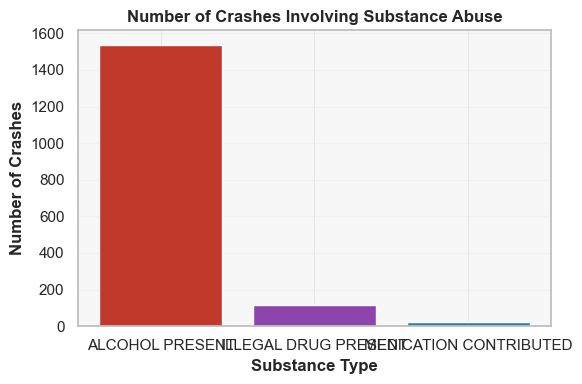

In [136]:
substance_df = df[df["Driver Substance Abuse"].isin(
    ["ALCOHOL PRESENT" , "ILLEGAL DRUG PRESENT" , "MEDICATION CONTRIBUTED" ]
)]

# Count crashes by substance type
counts = substance_df["Driver Substance Abuse"].value_counts()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(
    counts.index,
    counts.values,
    color=["#c0392b", "#8e44ad", "#2980b9"]
)

plt.title("Number of Crashes Involving Substance Abuse")
plt.xlabel("Substance Type")
plt.ylabel("Number of Crashes")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


#### 3.3.2 Driver Distraction


In [137]:
# Group distraction into broader categories
def categorize_distraction(val):
    v = str(val).lower()
    if "not distracted" in v:
        return "Not Distracted"
    if "inattention" in v or "looked but did not see" in v:
        return "Inattention"
    if "phone" in v or "text" in v or "cell" in v or "other occupants" in v or "inside" in v:
        return "Internal Distraction"
    if "outside" in v or "external" in v or "pedestrian" in v or "object" in v:
        return "External Distraction"
    return "Other"

df["Distraction Group"] = df["Driver Distracted By"].apply(categorize_distraction)
distract_pct = df["Distraction Group"].value_counts(normalize=True).mul(100).round(2)
distract_pct


Distraction Group
Not Distracted          62.47
Other                   23.59
Inattention             12.50
External Distraction     0.75
Internal Distraction     0.69
Name: proportion, dtype: float64

#### 3.3.3 Vehicle Equipment Problems


In [ ]:
equip_pct = df["Equipment Problems"].value_counts(normalize=True).mul(100).round(2)
equip_pct


#### 3.3.4 Vehicle Movement (vs Vehicle Damage Extent)


In [ ]:
# Collapse vehicle movement into broader categories
def movement_group(v):
    s = str(v).lower()
    if "park" in s or "stopped" in s or "stationary" in s:
        return "Stationary"
    if "turn" in s or "u turn" in s or "lane" in s:
        return "Turning"
    if "start" in s:
        return "Starting"
    if "traffic" in s or "enter" in s or "leave" in s:
        return "Traffic"
    if "skid" in s or "slow" in s or "stop" in s or "pass" in s:
        return "Maneuvering"
    return "In Motion"

df["Movement Group"] = df["Vehicle Movement"].apply(movement_group)
movement_damage = pd.crosstab(df["Movement Group"], df["Vehicle Damage Extent"], normalize="index")
movement_damage.round(3)


### 3.4 Environmental Impact
#### 3.4.1 Weather Condition and Surface Condition


In [ ]:
# Group weather and surface condition
def weather_group(v):
    s = str(v).lower()
    if any(k in s for k in ["rain", "snow", "fog", "sleet", "ice", "adverse"]):
        return "Adverse"
    return "Clear"

def surface_group(v):
    s = str(v).lower()
    if "dry" in s:
        return "Dry"
    if "wet" in s:
        return "Wet"
    if "snow" in s or "ice" in s:
        return "Snow/Ice"
    return "Other"

df["Weather Group"] = df["Weather"].apply(weather_group)
df["Surface Group"] = df["Surface Condition"].apply(surface_group)

ws_damage = pd.crosstab([df["Weather Group"], df["Surface Group"]], df["Vehicle Damage Extent"], normalize="index")
ws_damage.round(3).head(10)


#### 3.4.2 Speed Limit (binned) vs Vehicle Damage Extent


In [ ]:
# Speed limit bins with 55+
if "Speed Limit" in df.columns:
    def speed_bin(x):
        try:
            x = float(x)
        except Exception:
            return "Unknown"
        if x >= 55:
            return "55+"
        return str(int(x))
    df["Speed Bin"] = df["Speed Limit"].apply(speed_bin)
    speed_damage = pd.crosstab(df["Speed Bin"], df["Vehicle Damage Extent"], normalize="index")
    speed_damage.round(3).head(10)


#### 3.4.3 Light Condition and Traffic Control vs Injury Severity


In [ ]:
# Heatmaps by injury severity
injury_levels = df["Injury Severity"].value_counts().index[:4]
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.flatten()
for ax, level in zip(axes, injury_levels):
    sub = df[df["Injury Severity"] == level]
    ct = pd.crosstab(sub["Traffic Control"], sub["Light"], normalize="index")
    sns.heatmap(ct, ax=ax, cmap="Blues")
    ax.set_title(f"Injury: {level}")
    ax.set_xlabel("Light")
    ax.set_ylabel("Traffic Control")
plt.tight_layout()
plt.show()


#### 3.4.4 Chi-Square Tests


In [ ]:
try:
    from scipy.stats import chi2_contingency
    tests = []
    indep_vars = ["Surface Condition", "Weather", "Traffic Control", "Light", "Speed Bin"]
    for y in ["Vehicle Damage Extent", "Injury Severity"]:
        for x in indep_vars:
            if x in df.columns and y in df.columns:
                ct = pd.crosstab(df[x], df[y])
                chi2, p, dof, _ = chi2_contingency(ct)
                tests.append({"Dependent": y, "Independent": x, "p_value": p, "Significant(p<0.01)": p < 0.01})
    chi_table = pd.DataFrame(tests)
    chi_table
except Exception as e:
    print("Chi-square tests skipped:", e)


### 3.5 Vehicle Condition
#### 3.5.1 Vehicle Age


In [16]:
if "Vehicle Age" in df.columns:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x="Vehicle Damage Extent", y="Vehicle Age")
    plt.axhline(df["Vehicle Age"].mean(), color="red", linestyle="--", label="Average")
    plt.title("Vehicle Age by Damage Extent")
    plt.xlabel("Vehicle Damage Extent")
    plt.ylabel("Vehicle Age")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


#### 3.5.2 Vehicle Size


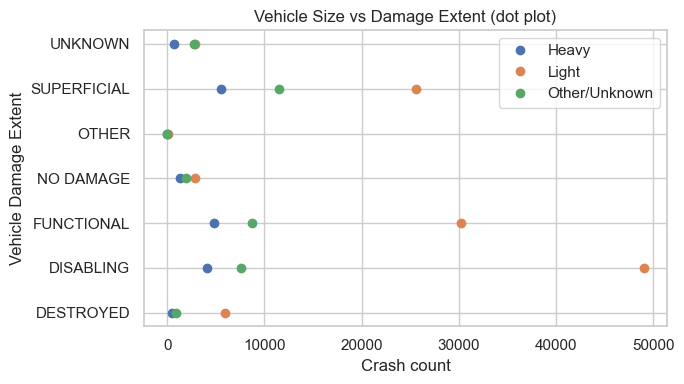

In [17]:
# Categorize vehicle body types into size groups
def size_group(v):
    s = str(v).lower()
    if any(k in s for k in ["motorcycle", "moped"]):
        return "Light"
    if any(k in s for k in ["passenger", "sedan", "coupe", "hatch", "convertible"]):
        return "Light"
    if any(k in s for k in ["van", "suv", "pickup", "truck"]):
        return "Heavy"
    return "Other/Unknown"

df["Vehicle Size"] = df["Vehicle Body Type"].apply(size_group)
size_damage = df.groupby(["Vehicle Size", "Vehicle Damage Extent"]).size().reset_index(name="count")

# Cleveland dot plot
plt.figure(figsize=(7,4))
for size in size_damage["Vehicle Size"].unique():
    sub = size_damage[size_damage["Vehicle Size"] == size]
    plt.plot(sub["count"], sub["Vehicle Damage Extent"], "o", label=size)
plt.title("Vehicle Size vs Damage Extent (dot plot)")
plt.xlabel("Crash count")
plt.ylabel("Vehicle Damage Extent")
plt.legend()
plt.tight_layout()
plt.show()


## 5. Conclusion
Summarize key patterns from the results (hotspots, time patterns, driver/vehicle factors, environment, vehicle conditions).
Limitations: The dataset covers crashes only (no exposure data), includes missing/unknown values, and may contain reporting inconsistencies.
Future work: Add exposure data (traffic volume), expand geography, and perform more rigorous causal analysis.
